In [1]:
# Install TA-lib and, ccxt, optuna
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%pip install Ta-Lib
%pip install ccxt
%pip install optuna

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the repository
repo_path = '/content/drive/MyDrive/tradingBot'
%cd {repo_path}

# Pull the latest changes
!git pull origin main

UsageError: Line magic function `%wget` not found.


In [1]:
from model_utils import CryptoDataset, check_for_missing_data, normalize_data, create_targets, create_features, feature_cut, profitable_percent, distribution, pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from optuna.pruners import SuccessiveHalvingPruner
import numpy as np

2025-01-02 23:50:43.236146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735887043.281732   10466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735887043.298077   10466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 23:50:43.342555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please

In [2]:
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.config.list_physical_devices('GPU'))  # Should list your GPU

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
from datetime import datetime, timedelta

# Define the end date
end_date = datetime(2024, 12, 31)

# Calculate the number of days in 500,000 minutes
minutes = 600000
days = minutes / (24 * 60)

# Calculate the start date
start_date = end_date - timedelta(days=days)

print(f"{minutes} minutes before {end_date.strftime('%Y-%m-%d')} is {start_date.strftime('%Y-%m-%d')}")

600000 minutes before 2024-12-31 is 2023-11-10


In [33]:
600000 / 20 / 500

60.0

In [39]:
downloads = CryptoDataset('ETHUSDT', '1m', '2023-12-10 00:00:00', '2024-12-31 00:00:00', version='600k')
downloads.fetch()
downloads.save()

Fetched data from 2023-12-10 00:00:00 to 2023-12-10 08:19:00
Fetched data from 2023-12-10 08:20:00 to 2023-12-10 16:39:00
Fetched data from 2023-12-10 16:40:00 to 2023-12-11 00:59:00
Fetched data from 2023-12-11 01:00:00 to 2023-12-11 09:19:00
Fetched data from 2023-12-11 09:20:00 to 2023-12-11 17:39:00
Fetched data from 2023-12-11 17:40:00 to 2023-12-12 01:59:00
Fetched data from 2023-12-12 02:00:00 to 2023-12-12 10:19:00
Fetched data from 2023-12-12 10:20:00 to 2023-12-12 18:39:00
Fetched data from 2023-12-12 18:40:00 to 2023-12-13 02:59:00
Fetched data from 2023-12-13 03:00:00 to 2023-12-13 11:19:00
Fetched data from 2023-12-13 11:20:00 to 2023-12-13 19:39:00
Fetched data from 2023-12-13 19:40:00 to 2023-12-14 03:59:00
Fetched data from 2023-12-14 04:00:00 to 2023-12-14 12:19:00
Fetched data from 2023-12-14 12:20:00 to 2023-12-14 20:39:00
Fetched data from 2023-12-14 20:40:00 to 2023-12-15 04:59:00
Fetched data from 2023-12-15 05:00:00 to 2023-12-15 13:19:00
Fetched data from 2023-1

Statistical Metrics for each Look-Ahead Period:
Look-Ahead 1 minutes:
  Mean: 0.0001%
  Median: 0.0000%
  Std Dev: 0.0926%
  Variance: 0.0086

Look-Ahead 3 minutes:
  Mean: 0.0003%
  Median: 0.0000%
  Std Dev: 0.1527%
  Variance: 0.0233

Look-Ahead 5 minutes:
  Mean: 0.0005%
  Median: 0.0000%
  Std Dev: 0.1944%
  Variance: 0.0378

Look-Ahead 10 minutes:
  Mean: 0.0009%
  Median: 0.0000%
  Std Dev: 0.2722%
  Variance: 0.0741

Look-Ahead 15 minutes:
  Mean: 0.0014%
  Median: 0.0014%
  Std Dev: 0.3319%
  Variance: 0.1102

Look-Ahead 30 minutes:
  Mean: 0.0028%
  Median: 0.0065%
  Std Dev: 0.4710%
  Variance: 0.2218

Look-Ahead 60 minutes:
  Mean: 0.0057%
  Median: 0.0116%
  Std Dev: 0.6710%
  Variance: 0.4502



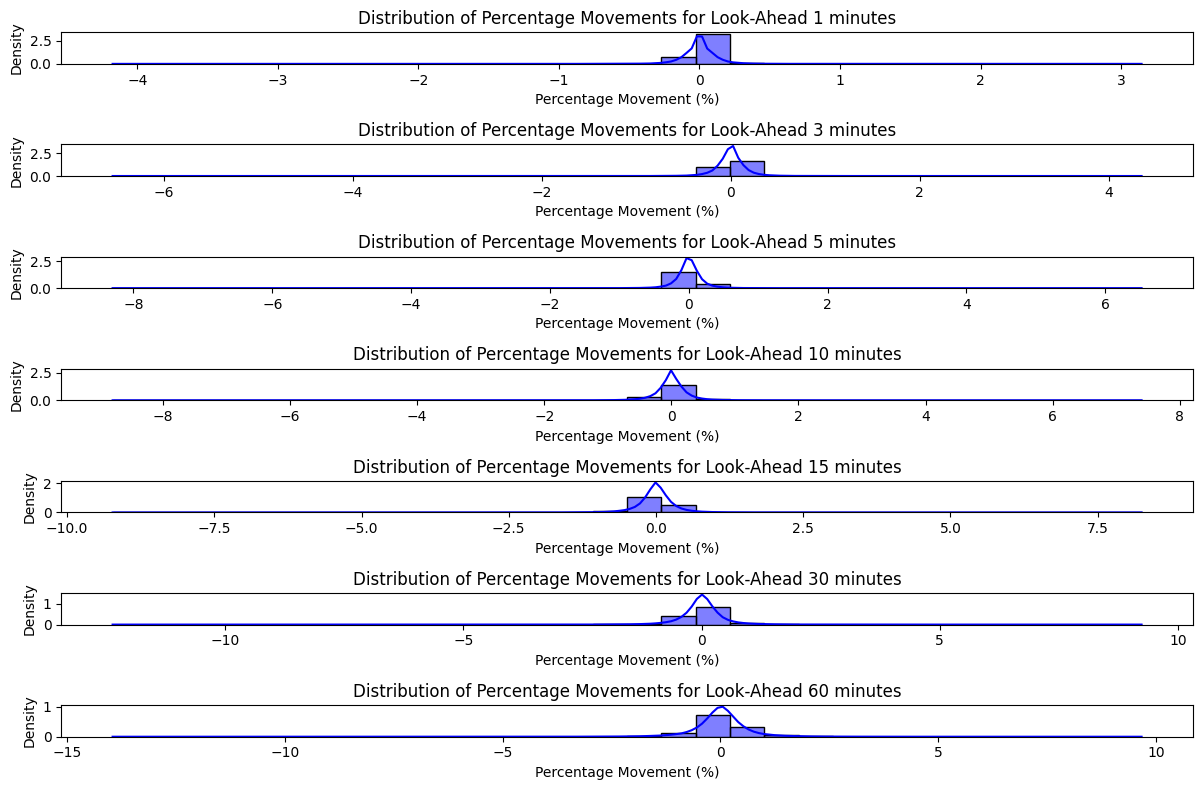

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your own ETH data)
# Make sure you have a dataframe with 'timestamp' and 'close' columns
df = pd.read_csv("data/ETHUSDT_1m_v600k.csv")  # Replace with your actual file
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample to a specific timeframe (for example, 5-minute candles)
#df_resampled = df.resample('5T').ohlc()  # '5T' is 5-minute interval

# Create a function to calculate percentage movement for different look-ahead periods
def calculate_percentage_movement(df, look_ahead_values):
    percentage_movements = {}
    
    for look_ahead in look_ahead_values:
        movements = []

        # Loop through each row in the dataset and calculate percentage change for each look-ahead period
        for i in range(len(df) - look_ahead):  # Make sure we don't go out of bounds
            current_price = df['close'].iloc[i]
            future_price = df['close'].iloc[i + look_ahead]
            percentage_movement = ((future_price - current_price) / current_price) * 100
            movements.append(percentage_movement)

        # Store all percentage movements for this look_ahead value
        percentage_movements[look_ahead] = movements
    
    return percentage_movements

# Define different look_ahead periods to test
look_ahead_values = [1, 3, 5, 10, 15, 30, 60]  # Look-ahead periods in number of 1-minute intervals

# Calculate percentage movements
percentage_movements = calculate_percentage_movement(df, look_ahead_values)

# Evaluate statistical metrics (mean, median, variance) for each look_ahead period
look_ahead_stats = {}

for look_ahead in look_ahead_values:
    movements = percentage_movements[look_ahead]
    look_ahead_stats[look_ahead] = {
        'mean': np.mean(movements),
        'median': np.median(movements),
        'std': np.std(movements),
        'variance': np.var(movements)
    }

# Print statistical metrics for each look-ahead period
print("Statistical Metrics for each Look-Ahead Period:")
for look_ahead, stats in look_ahead_stats.items():
    print(f"Look-Ahead {look_ahead * 1} minutes:")
    print(f"  Mean: {stats['mean']:.4f}%")
    print(f"  Median: {stats['median']:.4f}%")
    print(f"  Std Dev: {stats['std']:.4f}%")
    print(f"  Variance: {stats['variance']:.4f}")
    print()

# Plot distribution of percentage movements for each look-ahead period
plt.figure(figsize=(12, 8))

# Plot each look-ahead period's distribution
for look_ahead in look_ahead_values:
    plt.subplot(len(look_ahead_values), 1, look_ahead_values.index(look_ahead) + 1)
    sns.histplot(percentage_movements[look_ahead], kde=True, bins=30, color='blue', stat='density')
    plt.title(f"Distribution of Percentage Movements for Look-Ahead {look_ahead *1} minutes")
    plt.xlabel('Percentage Movement (%)')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()



In [3]:

# Objective function for optimization
def objective(trial):

    # MODEL CREATION
    params_grid = {
        # LSTM Units
        "lstm_units_1": trial.suggest_categorical("lstm_units_1", [64, 128, 256]),
        "lstm_units_2": trial.suggest_categorical("lstm_units_2", [32, 64, 128]),

        # Dropout rate for regularization
        "dropout": trial.suggest_categorical("dropout", [0.1, 0.2, 0.3, 0.5]),

        # Learning rate for the optimizer (log scale for better range)
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),

        # Batch size (common choices)
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),

        # Dense layer units (for fully connected layers after LSTM)
        "dense_units": trial.suggest_categorical("dense_units", [16, 32, 64, 128]),

        # Sequence length (historical data considered for prediction)
        "sequence_length": trial.suggest_categorical("sequence_length", [10, 20, 50, 100]),

        # Gradient clipping for preventing exploding gradients
        "gradient_clipping": trial.suggest_categorical("gradient_clipping", [0.5, 1.0, 2.0]),

        # Optimizer choice (Adam or RMSprop)
        "optimizer": trial.suggest_categorical("optimizer", ['adam', 'rmsprop']),

        # Activation function for layers
        "activation": trial.suggest_categorical("activation", ['relu', 'tanh'])
    }

    # DATA CREATION AND PROCESSING
    timeframe_filenames = {
    "1m": "data/ETHUSDT_1m_v600k.csv",
    "3m": "data/DOGEUSDT_3m_v0.csv",
    "5m": "data/DOGEUSDT_5m_v0.csv",
    "15m": "data/DOGEUSDT_15m_v0.csv",
    "30m": "data/DOGEUSDT_30m_v0.csv"
}
    # Timeframe to trade on
    timeframe = '1m'
    timeframe_file = timeframe_filenames[timeframe]
        
    # The number of indicators to be used in the model
    num_indicators = trial.suggest_int('num_indicators', 5, 46)
    
    # The scaler of the data
    scaler_type = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])
    
    # How big the look behind window is
    window_size = 80 #trial.suggest_int('window_size', 10, 135)  # Example range for window size
    
    # How far in the future to trade
    look_ahead_size = 20 #trial.suggest_int('look_ahead_size', 5, 50)

    # PROFIT FUNCTION VALUES
    # Create the simulate trading values
    #prediction_tolerance_max = trial.suggest_float('predTolMax', 0.8, 1)
    #prediction_tolerance_min = trial.suggest_float('predTolMin', 0.8, 1)
    # When to trade
    #trade_threshold = trial.suggest_float('trade_threshold', 0.0005, .02)

    # print everthing
    print(f'HyperParams: Timeframe: {timeframe_file}, Num Indicators: {num_indicators}, Scaler: {scaler_type}, Window Size: {window_size}, Look ahead Size: {look_ahead_size}, Dropout: {params_grid}')
    
    # run
    current_model = pipeline()
    current_model.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, params_grid)
    model = current_model.full_stack(trial=trial, filename=timeframe_file)
    
    # Calculate profit per trade per normalized time
    #timeframe_int = int(''.join(filter(str.isdigit, timeframe)))
    #total_profit, total_trades = current_model.full_stack(trial=trial, filename=timeframe_file)

    # Check if the trial is pruned after training
    if trial.should_prune():
        print("Trial pruned after training.")
        raise optuna.exceptions.TrialPruned()
    
    test_loss, test_mae = model.evaluate(current_model.X_test, current_model.y_test, verbose=1)
    
    return test_mae 
    


In [4]:
# JUST ONE TRIAL

pruner = SuccessiveHalvingPruner(
    min_resource=5,  # Minimum number of steps before evaluating
    reduction_factor=3,  # Fraction of trials to prune at each step
    min_early_stopping_rate=1  # Prevent pruning too early
)
# Create and run the Optuna study
study = optuna.create_study(direction='minimize', pruner=pruner)

study.optimize(objective, n_trials=1)  # Run 1 trial

# Get the best parameters
print("Best parameters:", study.best_params)

[I 2025-01-02 23:51:00,515] A new study created in memory with name: no-name-d4f4a243-1eb7-413c-b62e-578ab61aeb2c


HyperParams: Timeframe: data/ETHUSDT_1m_v600k.csv, Num Indicators: 14, Scaler: MinMaxScaler, Window Size: 80, Look ahead Size: 20, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.2, 'learning_rate': 0.0002725094538786082, 'batch_size': 16, 'dense_units': 64, 'sequence_length': 100, 'gradient_clipping': 1.0, 'optimizer': 'rmsprop', 'activation': 'tanh'}
Dataset loaded from data/ETHUSDT_1m_v600k.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split into model and test Sets


I0000 00:00:1735887080.182492   10466 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1
I0000 00:00:1735887084.236399   10730 cuda_dnn.cc:529] Loaded cuDNN version 90300


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0669 - mae: 0.1812 - val_loss: 0.0030 - val_mae: 0.0380
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0089 - mae: 0.0695 - val_loss: 0.0031 - val_mae: 0.0371
  1/188 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0018 - mae: 0.0338

/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0053 - mae: 0.0522 - val_loss: 0.0026 - val_mae: 0.0387
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0044 - mae: 0.0462 - val_loss: 0.0022 - val_mae: 0.0335
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0040 - mae: 0.0442 - val_loss: 0.0020 - val_mae: 0.0289
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0037 - mae: 0.0427 - val_loss: 0.0019 - val_mae: 0.0309
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0037 - mae: 0.0419 - val_loss: 0.0021 - val_mae: 0.0322
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0038 - mae: 0.0410 - val_loss: 0.0032 - val_mae: 0.0366
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0039 - mae: 0.0409 - val_loss: 0.0034 - val_mae: 0.0396
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0034 - mae: 0.0399 - val_loss: 0.0036 - val_mae: 0.0438
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0032 - mae: 0.0396 - val_loss: 0.0036 - val_mae: 0.0405
188/188 ━━━━━━━━━━━━━━━━━━━━

[I 2025-01-02 23:54:11,129] Trial 0 finished with value: 0.09826568514108658 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.2, 'learning_rate': 0.0002725094538786082, 'batch_size': 16, 'dense_units': 64, 'sequence_length': 100, 'gradient_clipping': 1.0, 'optimizer': 'rmsprop', 'activation': 'tanh', 'num_indicators': 14, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.09826568514108658.


Best parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout': 0.2, 'learning_rate': 0.0002725094538786082, 'batch_size': 16, 'dense_units': 64, 'sequence_length': 100, 'gradient_clipping': 1.0, 'optimizer': 'rmsprop', 'activation': 'tanh', 'num_indicators': 14, 'scaler': 'MinMaxScaler'}


In [ ]:

storage_path = "sqlite:///study.db"

optuna.delete_study(study_name="the_study", storage=storage_path)

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

#study = optuna.load_study(storage=storage_path, study_name="the_study")

# Create and run the Optuna study
study = optuna.create_study(storage=storage_path, study_name="the_study", direction='maximize', pruner=pruner)

study.optimize(objective, n_trials=100)  # Run 100 trials

# Get the best parameters
print("Best parameters:", study.best_params)


[I 2025-01-03 00:00:28,458] A new study created in RDB with name: the_study


HyperParams: Timeframe: data/ETHUSDT_1m_v600k.csv, Num Indicators: 33, Scaler: MinMaxScaler, Window Size: 80, Look ahead Size: 20, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.00010581353092970816, 'batch_size': 16, 'dense_units': 64, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'relu'}
Dataset loaded from data/ETHUSDT_1m_v600k.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split into model and test Sets


I0000 00:00:1735887655.844713   10726 service.cc:148] XLA service 0x7716b859aa30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735887655.852158   10726 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-01-03 00:00:56.005707: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  5/188 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 4594.8271 - mae: 34.5373

I0000 00:00:1735887661.195986   10726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8337.6182 - mae: 40.2875

In [ ]:
# Objective function for optimization
def custom_model(params):

    # model params
    model_keys = [
    'lstm_units_1', 'lstm_units_2', 'dropout', 'learning_rate', 'batch_size',
    'dense_units', 'sequence_length', 'gradient_clipping', 'optimizer', 'activation'
]
    # Create the new dictionary using dictionary comprehension
    params_grid = {key: params[key] for key in model_keys}

    # Get a file name for the timeframe
    timeframe_filenames = {
    "1m": "data/DOGEUSDT_1m_v0.csv",
    "3m": "data/DOGEUSDT_3m_v0.csv",
    "5m": "data/DOGEUSDT_5m_v0.csv",
    "15m": "data/DOGEUSDT_15m_v0.csv",
    "30m": "data/DOGEUSDT_30m_v0.csv"
}
    timeframe_file = timeframe_filenames[params['timeframe']]
    
    # run
    current_model = pipeline()
    current_model.pass_hyperparams(params['timeframe'], params['num_indicators'], params['scaler'], params['window_size'], params['look_ahead_size'], params_grid, params['predTolMax'], params['predTolMin'], params['trade_threshold'], params['sample_size'])
    
    current_model.full_stack(filename=timeframe_file)
   
    return current_model.model
    

In [ ]:
params = {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.000833475067744133, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 31, 'scaler': 'RobustScaler', 'window_size': 16, 'look_ahead_size': 40, 'predTolMax': 0.9303641151019011, 'predTolMin': 0.8728821078255877, 'trade_threshold': 0.016253333877016652}

model = custom_model(params)

In [ ]:
candles = raw


def get_trade(candles, params, model):
    
    # model params
    model_keys = [
    'lstm_units_1', 'lstm_units_2', 'dropout', 'learning_rate', 'batch_size',
    'dense_units', 'sequence_length', 'gradient_clipping', 'optimizer', 'activation'
]
    # Create the new dictionary using dictionary comprehension
    params_grid = {key: params[key] for key in model_keys}
    
    predictor_model = pipeline()
    predictor_model.pass_hyperparams(params['timeframe'], params['num_indicators'], params['scaler'], params['window_size'], params['look_ahead_size'], params_grid, params['predTolMax'], params['predTolMin'], params['trade_threshold'], 1)

    predictor_model.model = model
    predictor_model.preprocess()
    


In [6]:
i = 200

timeframe= '30m'
scaler_type = 'RobustScaler'

look_ahead_size = 40
dropout_rate = .2
num_indicators = 20
prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

while (i > 20):
    modelv1 = pipeline()
    window_size = i
    i -= 5
    print(f"Window Size: {window_size}")
    modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

    modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
    modelv1.preprocess()
    modelv1.target_creation()
    modelv1.split_data()
    modelv1.train()

Window Size: 200


TypeError: pipeline.pass_hyperparams() missing 1 required positional argument: 'sample_size'

In [18]:
timeframe= '30m'
num_indicators = 20
scaler_type = 'RobustScaler'
window_size = 151
look_ahead_size = 46
dropout_rate = .49

prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

modelv1 = pipeline()
modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
modelv1.preprocess()
modelv1.target_creation()
modelv1.split_data()

Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


In [19]:
np.isnan(modelv1.X_train).any()


np.False_

In [20]:


modelv1.train()

Epoch 1/50


2024-12-25 23:01:14.086057: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 449315600 exceeds 10% of free system memory.


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 174s 147ms/step - loss: 46026926833270784.0000 - mae: 8662324.0000 - val_loss: 292779263524864.0000 - val_mae: 274475.2500
Epoch 2/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 162s 139ms/step - loss: 6826168418304.0000 - mae: 26561.7988 - val_loss: 12004608000.0000 - val_mae: 4675.8516
Epoch 3/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 198s 170ms/step - loss: 52035971081243197440.0000 - mae: 106486480.0000 - val_loss: 6289352196169400320.0000 - val_mae: 118290536.0000
Epoch 4/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 181s 155ms/step - loss: 103412006487402217472.0000 - mae: 111667816.0000 - val_loss: 7336033779712.0000 - val_mae: 289142.3438
Epoch 5/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 149s 128ms/step - loss: 11993684362919936.0000 - mae: 4984188.0000 - val_loss: 70355142049792.0000 - val_mae: 795298.5000
Epoch 6/50
 479/1163 ━━━━━━━━━━━━━━━━━━━━ 1:28 129ms/step - loss: 686727555448832.0000 - mae: 1821143.7500

KeyboardInterrupt: 

In [4]:
modelv1.load_Model('Scaled')

I0000 00:00:1735018336.286763   11177 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
total_profit, X_test, y_test, y_train, predictions = modelv1.return_profit()

2024-12-23 22:32:19.036227: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 103540000 exceeds 10% of free system memory.
I0000 00:00:1735018339.421893   11456 service.cc:148] XLA service 0x7ed27c006120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735018339.421911   11456 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-23 22:32:19.448703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735018339.560770   11456 cuda_dnn.cc:529] Loaded cuDNN version 90300


 25/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

I0000 00:00:1735018340.007764   11456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Predictions:[[ 0.017639   -0.01618808]
 [ 0.01709265 -0.01639809]
 [ 0.03048979 -0.0284367 ]
 [ 0.02442027 -0.02138515]
 [ 0.047548   -0.03698634]
 [ 0.01369887 -0.0134461 ]
 [ 0.01835247 -0.01714688]
 [ 0.02041945 -0.02195122]
 [ 0.01888651 -0.01614244]
 [ 0.02414487 -0.02079504]]
Y-Tests:[[ 0.00485437 -0.00970874]
 [-0.00283286 -0.01983003]
 [ 0.01490826 -0.03555046]
 [ 0.02336449  0.00155763]
 [-0.01451613 -0.14354839]
 [ 0.00412882 -0.0015139 ]
 [ 0.06666667  0.00296296]
 [-0.00286944 -0.06025825]
 [ 0.0049505  -0.03041018]
 [ 0.00142349 -0.02918149]]
TP:[0, 0, np.float32(0.028965302), np.float32(0.023199258), np.float32(0.045170598), 0, 0, np.float32(0.019398475), 0, np.float32(0.022937626)]
SL:[0, 0, np.float32(-0.027014868), np.float32(-0.02031589), np.float32(-0.035137028), 0, 0, np.float32(-0.02085366), 0, np.float32(-0.019755285)]
Tot Profit: -57.683440510754934, Wins: 3430, Loses: 1640, No-trade: 5284


In [10]:
len(predictions)

10354

2024-12-23 22:32:30,170 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,176 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,181 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-23 22:32:30,184 - DEBUG - findfont: score(FontEntry(fname='/

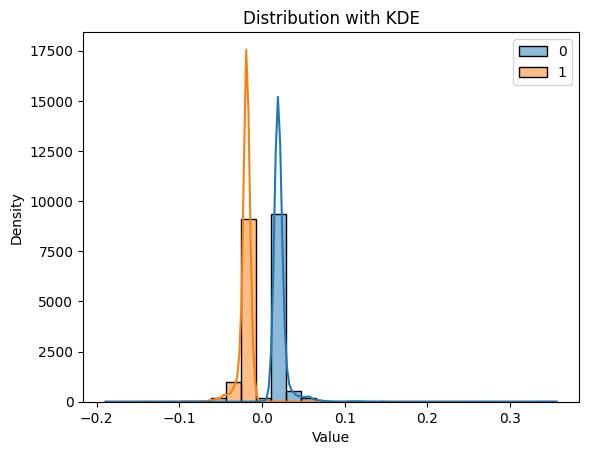

In [6]:
distribution(predictions)

In [33]:
# Make predictions
predictions = model.predict(X_test)

# Extract actual mix and max percentage changes
actual_max = [pair[0] for pair in y_test]
actual_min = [pair[1] for pair in y_test]

# Extract predicted max and min percentage changes
predicted_max = predictions[:, 0]
predicted_min = predictions[:, 1]

max_difference = actual_max - predicted_max


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


In [ ]:
import matplotlib.pyplot as plt # This sets the appropriate backend for Jupyter notebooks


import numpy as np

cut = 25
max_difference_cut = [max_difference[i]*100 for i in range(len(max_difference)) if i % cut == 0]

# max cuts
predicted_max_cut = [predicted_max[i]*100 for i in range(len(predicted_max)) if i % cut == 0]
actual_max_cut = [actual_max[i]*100 for i in range(len(actual_max)) if i % cut == 0]

# min cuts
predicted_min_cut = [predicted_min[i]*100 for i in range(len(predicted_min)) if i % cut == 0]
actual_min_cut = [actual_min[i]*100 for i in range(len(actual_min)) if i % cut == 0]

#df = pd.DataFrame(X_test)
#y_test = df.iloc[:, 2].to_numpy()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Size of the figure
#plt.plot(max_difference_25, label='Variation', color='green')  # Plot actual values
plt.plot(actual_max_cut, label='Actual', color='red')  # Plot actual values
plt.plot(predicted_max_cut, label='Predicted', color='blue')  # Plot predicted values

# Add labels and title
plt.xlabel('Index')  # You can also use time or other labels
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')

# Show legend
plt.legend()

# Show the plot
plt.show()


NameError: name 'max_difference' is not defined